# 2D projections for DNN-based reconstruction


In [1]:
%pylab inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from matplotlib.patches import Ellipse
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd
import sys

# Add the Utilties directory to the system path so the file sipm_param can be imported.
sys.path.append("../Utilities")
from sipm_param import *

# Plan:
# - plot one slice
# - histogram over many slices: x-extent, y-extent
# - plot several indicative slices
# - package slices of interest into HDF5 file for training

Using Theano backend.


In [19]:
# Define the 3D grid extent and range limits in PIXELS
NX = 200
NY = 200
NZ = 200

# Pixel and slice sizes in PIXELS
vSizeX = 1
vSizeY = 1
slice_width = 5.

# Range limit in x-y for slices in PIXELS
RNG_LIM = 100

# Number of SiPMs in response map
nsipm = 10

# Geometry definition.
nsipm = 10
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# Variables for computing an EL point location.
xlen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
wbin = 2.0                                    # (mm) bin width

# Compute the positions of the SiPMs.
pos_x = np.ones(nsipm**2)*sipm_edge_width + (np.ones(nsipm*nsipm)*range(nsipm**2) % nsipm)*sipm_pitch
pos_y = np.ones(nsipm**2)*sipm_edge_width + np.floor(np.ones(nsipm*nsipm)*range(nsipm**2) / nsipm)*sipm_pitch

First load the HDF5 file containing a list of 3D pixels for each event with nonzero energy.

In [15]:
h5f = h5py.File("/Users/josh/Dropbox/IFIC/vox_dnn_bb0nu_dnn_111_1x1x1.h5")
Ntrks = len(h5f)

Define a functions to slice an event.

In [16]:
# Create slices for the specified event.
#  hfile: the HDF5 files containing the events
#  nevt: the event number to slice
#  zwidth: the slice width in mm
#
#  returns: [energies, slices]
#   where energies is a list of the energies in each slice
#   and slices is a matrix of size [Nslices,NY,NX] containing normalized slices
def slice_evt(hfile,nevt,zwidth):
    
    # Get the event from the file.
    htrk = hfile['trk{0}'.format(nevt)]
    
    # Get the z-range.
    zmin = np.min(htrk[2]); zmax = np.max(htrk[2])
    
    # Create slices of width zwidth beginning from zmin.
    nslices = int(math.ceil((zmax - zmin)/zwidth))
    #print "{0} slices for event {1}".format(nslices,nevt)
    
    slices = np.zeros([nslices,NY,NX])
    energies = np.zeros(nslices)
    for x,y,z,e in zip(htrk[0],htrk[1],htrk[2],htrk[3]):
        
        # Add the energy at (x,y,z) to the (x,y) value of the correct slice.
        islice = int((z - zmin)/zwidth)
        if(islice == nslices): islice -= 1
        slices[islice][y][x] += e
        energies[islice] += e
    
    # Normalize the slices.
    for s in range(nslices):
        slices[s] /= energies[s]
        
    # Return the list of slices and energies.
    return [energies, slices]

Save slices from all events that lie within a certain range.

In [17]:
# Create the HDF5 file.
h5slices = h5py.File("slices.h5",'w')

xrng = []; yrng = []   # x- and y-ranges
nspevt = []            # number of slices per event
slices_x = []; slices_y = []; slices_e = []   # slice arrays
for ee in range(20):
    
    if(ee % int(Ntrks/100) == 0):
        print "Slicing event {0}".format(ee)
        
    # Slice the event.
    en,sl = slice_evt(h5f,ee,slice_width)
    nslices = len(en)
    nspevt.append(nslices)
    
    # Get information about each slice.
    for ss in range(nslices):
        
        # Don't include 0-energy slices.
        if(en[ss] < 1.0e-6):
            continue
        
        # Get lists of the nonzero x,y,z indices and E values.
        cslice = sl[ss]
        nzy,nzx = np.nonzero(cslice)
        nze = cslice[np.nonzero(cslice)]
        
        # Extract several quantities of interest.
        xmin = np.min(nzx); xmax = np.max(nzx)
        ymin = np.min(nzy); ymax = np.max(nzy)
        xrng.append(xmax - xmin + 1)
        yrng.append(ymax - ymin + 1)
        
        # Save the slice if within range.
        if(xmax - xmin > RNG_LIM or ymax - ymin > RNG_LIM):
            print "Range of {0} for event {1} slice {2}, energy {3}; slice not included".format(xmax-xmin,ee,ss,en[ss])
        else:
            
            # Center the slices about RNG_LIM/2.
            x0 = (xmin + xmax)/2. - RNG_LIM/2.
            y0 = (ymin + ymax)/2. - RNG_LIM/2.
            nzx -= x0; nzy -= y0
            
            # Create the slice array.
            snum = len(slices_x)
            slices_x.append(nzx); slices_y.append(nzy); slices_e.append(nze)
            carr = np.array([nzx, nzy, nze])
            
            # Create the corresponding SiPM map.
            sipm_map = np.zeros(nsipm*nsipm)
            for xpt,ypt,ept in zip(xpts,ypts,epts):

                # Compute the distances and probabilities.  Add the probabilities to the sipm map.
                rr = np.array([math.sqrt((xi - xpt)**2 + (yi - ypt)**2) for xi,yi in zip(pos_x,pos_y)])
                probs = 0.5*(sipm_par(0, rr) + sipm_par(1, rr))
                sipm_map += probs*ept

            # Normalize the probability map, and set sigma = 1.
            sipm_map -= np.mean(sipm_map)
            sipm_map /= np.std(sipm_map)
            
            # Save the slice and the SiPM map to an HDF5 file.
            h5slices.create_dataset("slice{0}".format(snum),data=carr)
            h5slices.create_dataset("sipm{0}".format(snum),data=sipm_map)
            
h5slices.close()

Slicing event 0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Histogram several quantities of interest.

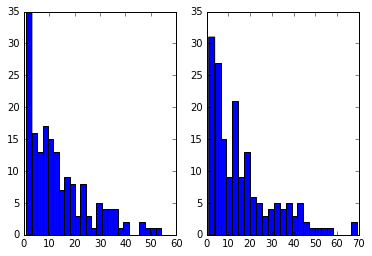

In [22]:
# Plot the histograms.
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(xrng,bins=25)

ax2 = fig.add_subplot(122)
ax2.hist(yrng,bins=25)

plt.show()

Slice one event and plot one slice (full range).

In [23]:
en,sl = slice_evt(h5f,23,5.)
max_en = np.where(en == en.max())[0][0]
print en
print max_en

# Get lists of the nonzero x,y,z indices and E values.
pslice = sl[3]#sl[max_en]
nzy,nzx = np.nonzero(pslice)
nze = pslice[np.nonzero(pslice)]

# Combine into one single 4 x N array, where N is the number of nonzero elements.
#carr = np.array([nzx, nzy, nzz, nze]);

# Create the plot.
fig = plt.figure()
ax1 = fig.add_subplot(111)
hxz, xxz, yxz = np.histogram2d(nzy, nzx, weights=nze, normed=False, bins=(NY, NX), range=[[0,NY],[0,NX]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax1.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (keV)');

plt.show()

ValueError: Not a location (Invalid object id)

Close the HDF5 file containing the pixels of the event.

In [21]:
h5f.close()

# Reconstruction with DNNs

The stored events and SiPM maps can now be read in and used to train a DNN.

In [ ]:
# Number of events to read.
Nevts_train = 4000
Nevts_test = 400
gridSize = int(RNG_LIM*RNG_LIM)
mapSize = nsipm*nsipm

x_train = np.zeros([Nevts_train,mapSize])
x_test = np.zeros([Nevts_test,mapSize])
y_train = np.zeros([Nevts_train,gridSize])
y_test = np.zeros([Nevts_test,gridSize])

# Open the HDF5 file.
evtFile = h5py.File("slices.h5",'r')

# Start reading the events.
nevents = len(evtFile)
for ee in range(nevents):
    
    # Get the data from the HDF5 file.
    slice_obj = evtFile["slice{0}".format(ee)]
    map_obj = evtFile["sipm{0}".format(ee)]
    
    # Create the grid.
    xslices = slice_obj[0]; yslices = slice_obj[1]; eslices = slice_obj[2]
    slice_grid = np.zeros(gridSize)
    for xv,yv,ev in zip(xslices,yslices,eslices):
        igrid = xv + RNG_LIM*yv
        slice_grid[igrid] += ev
    
    # Store the event.
    if(nn >= Nevts_train): 
        x_test[nn-Nevts_train] = map_obj
        y_test[nn-Nevts_train] = slice_grid
    else:
        x_train[nn] = map_obj
        y_train[nn] = slice_grid

In [ ]:
# Construct a DNN.
model = Sequential()
model.add(Dense(output_dim=1024, input_dim=nsipm*nsipm))
model.add(Activation("relu"))
model.add(Dense(output_dim=1024))
model.add(Activation("relu"))
model.add(Dense(output_dim=1024))
model.add(Activation("relu"))
model.add(Dense(output_dim=2*N_ELpts))
model.add(Activation("sigmoid"))
model.compile(loss='mse', optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
model.summary()

In [ ]:
model.fit(x_train, y_train, nb_epoch=100, batch_size=100);

In [ ]:
# Evaluate the model and produce a list of predictions for the test data.
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=100);
y_pred = model.predict(x_test, batch_size=32, verbose=0)
print("\nMean loss is {0}".format(loss_and_metrics))

In [ ]:
# Plot one event.
plt_train = False
pevt = 4
fig = plt.figure();
ax1 = fig.add_subplot(111);
ax1.axis([0, xlen, 0, ylen]);

if(plt_train):
    xarr = x_train[pevt]
    yarr = y_train[pevt]
else:
    xarr = x_test[pevt]
    yarr = y_test[pevt]

# Create circles and plot them according to the probabilities.
probs = (xarr - min(xarr))
probs /= max(probs)
for x,y,p in zip(pos_x, pos_y, probs):

    #print "Placing sipm at ({0},{1}) with prob {2}".format(x,y,p);
    
    # Set up the location; note we must invert y due to a pi rotation
    #  about the x-axis.
    r = Ellipse(xy=(x,y), width=2., height=2.);
    r.set_facecolor('0');
    r.set_alpha(0.02 + 0.98*p);
    ax1.add_artist(r);

# Place large blue circles for actual EL points.
for npt in range(len(yarr)/2):
    xpt = yarr[2*npt]*xlen
    ypt = yarr[2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
    mrk.set_facecolor('b');
    ax1.add_artist(mrk);
    
# Place small red circles for predicted EL points.
for npt in range(len(y_pred[pevt])/2):
    xpt = y_pred[pevt][2*npt]*xlen
    ypt = y_pred[pevt][2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    mrk.set_facecolor('r');
    ax1.add_artist(mrk);

# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");